<h1 style="text-align: center; color: darkblue;">Evaluation and Inference</h1>

### 📑 <font color='blue'> Table of Contents </font>
1. [Introduction](#1)
2. [Setup](#2)
3. [Load best run and artifacs](#3)
4. [Results and visualization](#4)
5. [Inference](#5)

## <a id="1" style="color: darkred; text-decoration: none;">1. Introduction</a>

This notebook showcases the results of the project. It loads the trained model and associated artifacts from MLflow, evaluates performance on the test set using metrics and visualizations, and demonstrates how to perform inference on new data. The goal is to provide a clear overview of the model’s effectiveness and practical usage.

## <a id="2" style="color: darkred; text-decoration: none;">2. Setup</a>

In [78]:
import mlflow
import pickle
import os
import json
import mlflow.tensorflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

In [58]:
EXPERIMENT_NAME = 'Tuning'

## <a id="3" style="color: darkred; text-decoration: none;">3. Load best run and artifacts</a>

**Get best run**

First, we will retrieve the best run from our experiment.

In [62]:
# auxiliary fn. to get the best run according to our criterion
def get_best_run(runs, recall_threshold=0.8, metric_priority="f1_score"):
    """
    Select the best run based on recall threshold and a priority metric.
    
    Args:
        runs (list of dict): Each dict should contain:
            - "metrics" (dict)
            - "params" (dict)
            - "tags" (dict)
            - "run_id" (str)
            - "artifact_uri" (str)
        recall_threshold (float): Minimum recall to be considered a candidate.
        metric_priority (str): Metric to use when multiple candidates meet threshold.

    Returns:
        dict: The best run dictionary.
    """
    # Filter candidates by recall
    candidates = [r for r in runs if r["metrics"].get("recall", 0) >= recall_threshold]

    # Pick best among candidates
    if candidates:
        return max(candidates, key=lambda r: r["metrics"].get(metric_priority, float("-inf")))

    # Fallback: best recall overall
    return max(runs, key=lambda r: r["metrics"].get("recall", float("-inf")))



In [61]:
# All experiments
exp = mlflow.search_experiments()

for e in exp:
    print(e.name)

Tuning
Default


In [64]:
# get experiment ID
client = MlflowClient()
experiment = client.get_experiment_by_name("Tuning")

if experiment is None:
    print("Experiment not found")
else:
    experiment_id = experiment.experiment_id
    print(f"ID={experiment_id}, Name={experiment.name}")

ID=883784391983338726, Name=Tuning


In [65]:
# --------------------------
# CONFIG
# --------------------------

tracking_uri = "http://127.0.0.1:5000"        # your MLflow server
experiment_id = experiment_id         # experiment ID from UI
metric_to_sort = "f1"                        # metric to choose the best run
artifact_paths = {
    "preprocessing": "preprocessing",       # folder under artifacts
    "plots": "plots",                        # folder under artifacts
    "model": "model"                         # model artifact path
}

# --------------------------
# SET TRACKING URI
# --------------------------
mlflow.set_tracking_uri(tracking_uri)

# --------------------------
# SEARCH BEST RUN
# --------------------------

runs_df = mlflow.search_runs(
    experiment_ids=[experiment_id],
    filter_string="tags.mlflow.runName = 'best_overall'", # ONLY SEARCHG in best runs
)


# Convert MLflow DataFrame to list of dicts
runs = []
for _, row in runs_df.iterrows():
    runs.append({
        "run_id": row["run_id"],
        "metrics": {k.replace("metrics.", ""): row[k] for k in row.index if k.startswith("metrics.")},
        "params": {k.replace("params.", ""): row[k] for k in row.index if k.startswith("params.")},
        "tags": {k.replace("tags.", ""): row[k] for k in row.index if k.startswith("tags.")},
        "artifact_uri": row["artifact_uri"]
    })

best_run = get_best_run(runs, recall_threshold=0.8, metric_priority="f1_score")
print("Best run ID:", best_run["run_id"])

# run id
run_id = best_run["run_id"]


Best run ID: a68ec97becd54a788b7f8bb004d9cdba


In [66]:
best_run

{'run_id': 'a68ec97becd54a788b7f8bb004d9cdba',
 'metrics': {'test_f1': 0.9638554294926511,
  'f1_score': 0.999999995,
  'test_precision': 0.9756097793579102,
  'accuracy': 1.0,
  'recall': 1.0,
  'precision': 1.0,
  'test_loss': 0.10903945565223694,
  'test_recall': 0.9523809552192688,
  'test_accuracy': 0.9736841917037964,
  'loss': 0.08276927471160889},
 'params': {'learning_rate': '0.00544853401907757',
  'model_name': 'model1',
  'dropout_rate': '0.4',
  'epochs': '2'},
 'tags': {'mlflow.user': 'marcos',
  'mlflow.source.git.commit': '511f649c4b1f4a58c853cb42c4ecc8e7ed1d7c2b',
  'mlflow.runName': 'best_overall',
  'mlflow.source.type': 'LOCAL',
  'mlflow.source.name': '/home/marcos/Escritorio/AI-prod/ML-Complete-Project/scripts/pipeline.py'},
 'artifact_uri': 'file:///home/marcos/Escritorio/AI-prod/ML-Complete-Project/mlruns/883784391983338726/a68ec97becd54a788b7f8bb004d9cdba/artifacts'}

**Load model**

In [67]:
# --------------------------
# LOAD MODEL
# --------------------------
model_uri = f"runs:/{run_id}/{artifact_paths['model']}"
model = mlflow.tensorflow.load_model(model_uri)
print("TensorFlow model loaded successfully!")

TensorFlow model loaded successfully!


In [68]:
model.summary()

Model: "model1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,293 (48.02 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,196 (32.02 KB)

**Load preprocessing artifacts**

In [69]:
# --------------------------
# DOWNLOAD PREPROCESSING ARTIFACTS
# --------------------------
preproc_dir = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path=artifact_paths["preprocessing"])
print("Preprocessing artifacts downloaded to:", preproc_dir)

# Load scaler
scaler_file = os.path.join(preproc_dir, "scaler.pkl")
with open(scaler_file, "rb") as f:
    scaler = pickle.load(f)

# Load encoder
encoder_file = os.path.join(preproc_dir, "encoder.pkl")
with open(encoder_file, "rb") as f:
    encoder = pickle.load(f)

# Load features
features_file = os.path.join(preproc_dir, "features.json")
with open(features_file, "r") as f:
    features = json.load(f)

print("Scaler, encoder, and features loaded successfully!")


Preprocessing artifacts downloaded to: /tmp/tmpwmywaj1c/preprocessing
Scaler, encoder, and features loaded successfully!


In [70]:
scaler.mean_

array([1.41559238e+01, 1.93511328e+01, 9.21518750e+01, 6.58153516e+02,
       9.61988672e-02, 1.03554531e-01, 8.85161713e-02, 4.88897402e-02,
       1.81255273e-01, 6.27087305e-02, 4.09529102e-01, 1.21794902e+00,
       2.90134512e+00, 4.10547617e+01, 6.94725781e-03, 2.51113359e-02,
       3.16497336e-02, 1.17416348e-02, 2.04345078e-02, 3.75897129e-03,
       1.63169453e+01, 2.57480273e+01, 1.07621934e+02, 8.86556445e+02,
       1.32138906e-01, 2.53280762e-01, 2.71695561e-01, 1.14682229e-01,
       2.90017188e-01, 8.38891016e-02])

In [71]:
encoder

{'M': 1, 'B': 0}

In [73]:
features

{'features': ['radius_mean',
  'texture_mean',
  'perimeter_mean',
  'area_mean',
  'smoothness_mean',
  'compactness_mean',
  'concavity_mean',
  'concave points_mean',
  'symmetry_mean',
  'fractal_dimension_mean',
  'radius_se',
  'texture_se',
  'perimeter_se',
  'area_se',
  'smoothness_se',
  'compactness_se',
  'concavity_se',
  'concave points_se',
  'symmetry_se',
  'fractal_dimension_se',
  'radius_worst',
  'texture_worst',
  'perimeter_worst',
  'area_worst',
  'smoothness_worst',
  'compactness_worst',
  'concavity_worst',
  'concave points_worst',
  'symmetry_worst',
  'fractal_dimension_worst']}

## <a id="4" style="color: darkred; text-decoration: none;">4. Results and visualization</a>

**Hyperparameters and metrics**

In [88]:
# --------------------------
# LOAD PARAMS AND METRICS
# --------------------------
params = best_run['params']
metrics = best_run['metrics']

In [89]:
# Extract params and metrics
params = best_run['params']
metrics = best_run['metrics']

# Convert to vertical DataFrames
params_df = pd.DataFrame(list(params.items()), columns=['Parameter', 'Value'])

# Separate test metrics (those starting with 'test_')
test_metrics = {k.replace('test_', ''): v for k, v in metrics.items() if k.startswith('test_')}
val_metrics = {k: v for k, v in metrics.items() if not k.startswith('test_')}

# Convert to vertical DataFrames
test_df = pd.DataFrame(list(test_metrics.items()), columns=['Metric', 'Value'])
val_df = pd.DataFrame(list(val_metrics.items()), columns=['Metric', 'Value'])

# Display
# Display
print("=== Parameters ===")
display(params_df)

print("\n=== Test Metrics ===")
display(test_df)

print("\n=== Validation Metrics ===")
display(val_df)


=== Parameters ===


,Parameter,Value
0,learning_rate,0.00544853401907757
1,model_name,model1
2,dropout_rate,0.4
3,epochs,2



=== Test Metrics ===


,Metric,Value
0,f1,0.963855
1,precision,0.975610
2,loss,0.109039
3,recall,0.952381
4,accuracy,0.973684



=== Validation Metrics ===


,Metric,Value
0,f1_score,1.000000
1,accuracy,1.000000
2,recall,1.000000
3,precision,1.000000
4,loss,0.082769


**Confusion Matrix** 

['roc_curve.png', 'confusion_matrix.png']


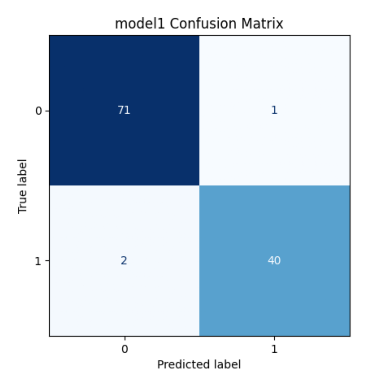

In [76]:
# Download the folder with plots
plots_dir = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="plots")

# Check what files exist
print(os.listdir(plots_dir))

# Build the full path (make sure spelling matches your saved file)
conf_matrix_path = os.path.join(plots_dir, "confusion_matrix.png")

# Load and display in Jupyter
img = mpimg.imread(conf_matrix_path)
plt.imshow(img)
plt.axis("off")
plt.show()

**ROC curve**

['roc_curve.png', 'confusion_matrix.png']


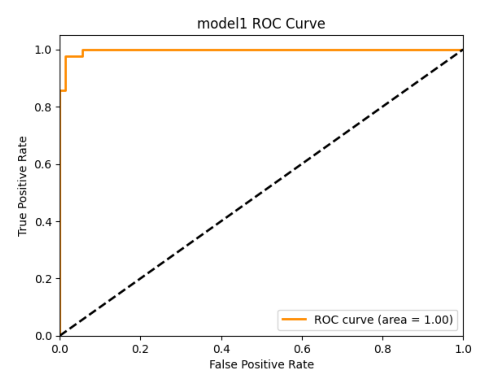

In [77]:
# Download the folder with plots
plots_dir = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="plots")

# Check what files exist
print(os.listdir(plots_dir))

# Build the full path (make sure spelling matches your saved file)
conf_matrix_path = os.path.join(plots_dir, "roc_curve.png")

# Load and display in Jupyter
img = mpimg.imread(conf_matrix_path)
plt.imshow(img)
plt.axis("off")
plt.show()

## <a id="5" style="color: darkred; text-decoration: none;">5. Inference</a>

In [79]:
# simulate new data
new_data = np.random.rand(30)

# Convert to DataFrame with proper column names
new_data_df = pd.DataFrame([new_data], columns=features['features'])

# apply scaler
scaled_data = scaler.transform(new_data_df)

scaled_data

array([[ -3.79698111,  -4.26071726,  -3.72354665,  -1.84541284,
         60.18743399,   3.26344415,  10.55497323,   1.80192528,
         12.46696597, 113.08789648,   0.82301143,  -2.09428162,
         -1.34886738,  -0.8606312 , 312.70719112,  47.55994733,
         21.06527852, 114.4087215 , 102.61743199, 269.70313485,
         -3.29194996,  -4.14491204,  -3.16454517,  -1.53661962,
         20.34449854,   0.32683159,   1.16786954,  -1.50141106,
          1.11866635,  17.54243469]])

In [80]:
y_pred = model.predict(scaled_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [52]:
y_pred

array([[1.8123825e-12]], dtype=float32)